In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sys, os
sys.path.append(os.path.join('..', 'scripts'))
import figure_utils as utils

In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy

import temporal_encoder_common
from temporal_encoder_common import Filters
import nengo
import dlop_ldn_function_bases as bases

In [52]:
def mk_gaussian_basis(q, N, T=1.0, dt=1e-3, skew=2.5):
    ts = np.arange(N) * dt
    mus = np.sort(1.0 - np.power(np.linspace(0, 1, q), skew)) * T
    sigmas = 0.02 + 0.6 * mus
    res = np.exp(-np.square(ts[None, :] - mus[:, None]) /
                 np.square(sigmas[:, None]))
    return res / (np.sqrt(dt * np.sum(res, axis=1)))[:, None]

def mk_rayleigh_basis(q, N, T=1.0, dt=1e-3, skew=1.0):
    ts = (np.arange(N) * dt)[None, :]
    sigmas = 0.1 + (1.0 - np.power(np.linspace(0, 1, q), skew)[:, None]) * T
    res = ts / np.square(sigmas) * np.exp(-np.square(ts) / (2.0 * np.square(sigmas)))
    return res / (np.sqrt(dt * np.sum(res, axis=1)))[:, None]

In [53]:
N_neurons = 200
dt = 1e-3

ts = np.arange(0, 10.0, dt)

Ms = mk_rayleigh_basis(N_neurons, len(ts), T=2.0, dt=dt, skew=0.33).T

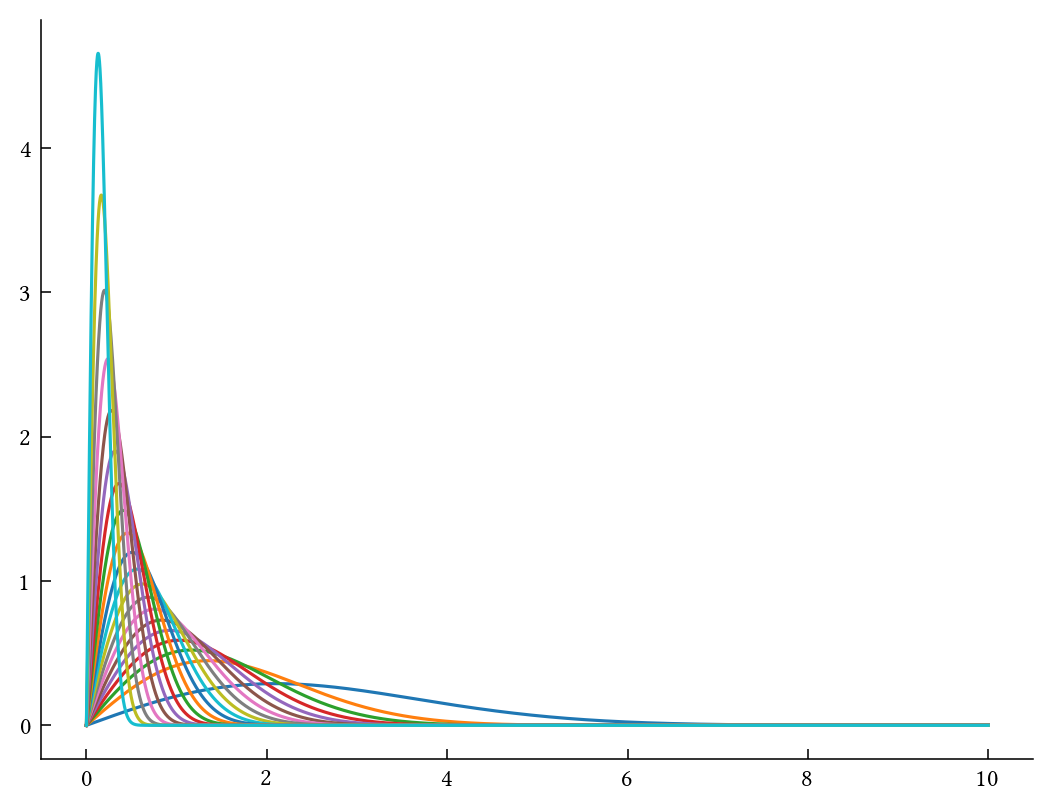

In [54]:
fig, ax = plt.subplots()
ax.plot(ts, Ms[:, ::10]);

In [55]:
rng = np.random.RandomState(7897)
gains = 100 * np.ones(N_neurons)
biases = rng.uniform(-10, 10, N_neurons)
Es = rng.choice([-1, 1], N_neurons)
TEs = np.diag(Es)
G = lambda x: x * (x > 0.0)

W_in, W_rec = temporal_encoder_common.solve_for_recurrent_population_weights(
    G,
    gains,
    biases,
    None,
    None,
    TEs,
    [Filters.lowpass(100e-3)],
    [Filters.lowpass(100e-3)],
    Ms=Ms,
    N_smpls=200,
    T=10.0,
    xs_sigma=0.5,
    xs_scale=2.5,
    biased=False,
)


100%|███████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.83it/s]


In [56]:
def pulse(t, gain=10.):
    return gain * (1.0 * (t < 0.1))

with nengo.Network() as model:
    nd_in = nengo.Node(pulse)
    ens_x = nengo.Ensemble(
        neuron_type=nengo.SpikingRectifiedLinear(),
        n_neurons=N_neurons,
        dimensions=1,
        bias=biases,
        gain=gains
    )

    nengo.Connection(nd_in,
                     ens_x.neurons,
                     transform=W_in[:, 0:1],
                     synapse=300e-3) # Slowing things down after-the-fact; this makes solving for weights faster

    nengo.Connection(ens_x.neurons,
                     ens_x.neurons,
                     transform=W_rec[:, :, 0],
                     synapse=300e-3)

    p_in = nengo.Probe(nd_in, synapse=None)
    p_out = nengo.Probe(ens_x.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(10.0)
    As = sim.data[p_out]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [57]:
def run_lti_experiment(A, B, tau=100e-3, theta=5.0, n_neurons=200):
    q = A.shape[0]
    Ap = np.eye(q) + A * tau / theta
    Bp = B * tau / theta

    with nengo.Network(seed=58312) as model:
        nd_in = nengo.Node(pulse)
        ens_x = nengo.Ensemble(
            neuron_type=nengo.SpikingRectifiedLinear(),
            n_neurons=n_neurons,
            dimensions=q,
            max_rates=nengo.dists.Uniform(50, 100),
        )

        nengo.Connection(nd_in,
                         ens_x,
                         transform=Bp[:, None],
                         synapse=tau)

        nengo.Connection(ens_x,
                         ens_x,
                         transform=Ap,
                         synapse=tau)

        p_in = nengo.Probe(nd_in, synapse=None)
        p_out = nengo.Probe(ens_x, synapse=100e-3)
        p_out_act = nengo.Probe(ens_x.neurons, synapse=None)

    with nengo.Simulator(model) as sim:
        sim.run(10.0)
        return sim.trange(), sim.data[p_out], sim.data[p_out_act]

In [58]:
# LDN data
q = 7
A_ldn, B_ldn = bases.mk_ldn_lti(q)
#A_ldn, B_ldn = np.zeros(q), np.ones(q)
_, ms_ldn, As_ldn = run_lti_experiment(A_ldn, B_ldn, theta=5.0)


# Mod. fourier data
def mk_mod_fourier_basis(q, N):
    N_tot = int(1.1 * N)
    return bases.mk_fourier_basis(q, int(N_tot))[:, (N_tot - N):]

M = mk_mod_fourier_basis(q, 10000)
A_mf, B_mf = bases.reconstruct_lti(M, dampen=True)
B_mf *= 0.1 # Need smaller input scale for some reason
_, ms_mf, As_mf = run_lti_experiment(A_mf, B_mf, theta=5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

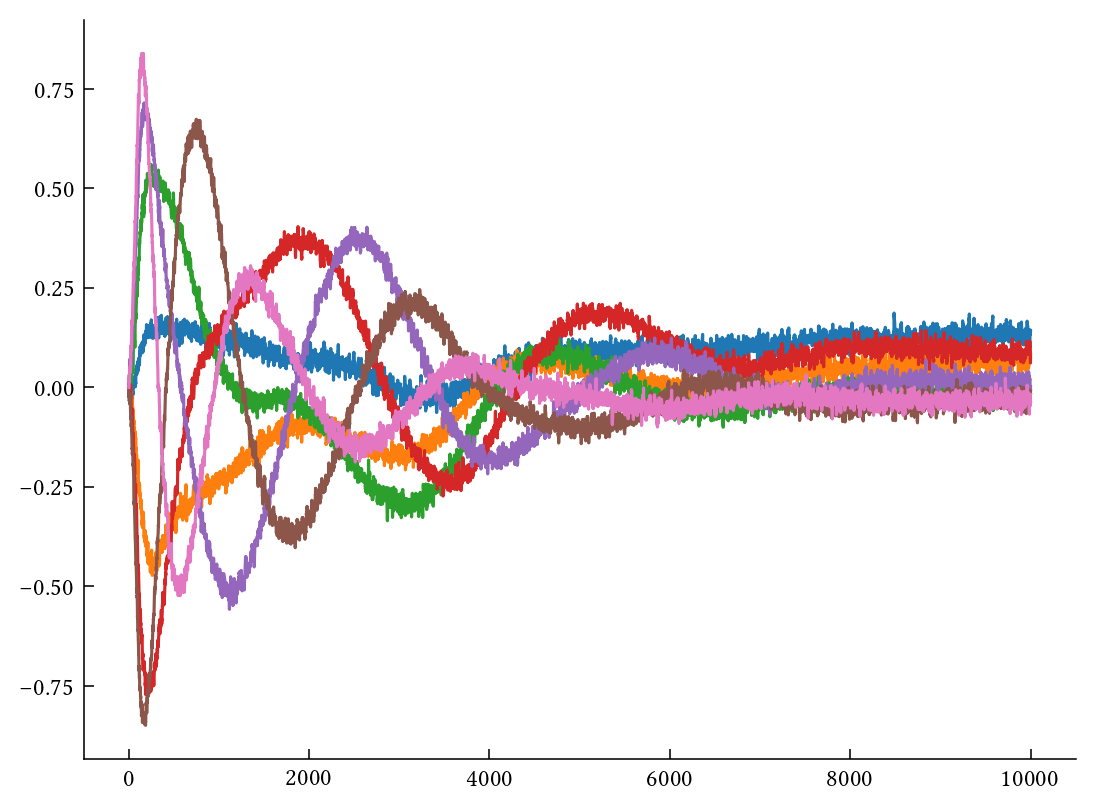

In [59]:
fig, ax = plt.subplots()
ax.plot(ms_ldn);

In [60]:
def post_process_As(ts, As, Es=None):
    if not Es is None:
        As = As[:, Es > 0]
    As_flt = nengo.synapses.Lowpass(tau=200e-3).filt(As)[200:5200]

    # Throw away silent neurons
    idx_nonsilent = np.max(As_flt, axis=0) > 1e-3
    As_flt = As_flt[:, idx_nonsilent]

    # Sort by maximum activity
    idx_max = np.argmax(As_flt, axis=0)
    idx_sort = np.argsort(idx_max)
    ts_sort = ts[idx_max][idx_sort]
    As_flt = As_flt[:, idx_sort]

    As_norm = As_flt / np.linalg.norm(As_flt, axis=1)[:, None]
    As_norm_per_neuron = As_flt / np.max(As_flt + 1e-9, axis=0)

    return ts_sort, As_flt, As_norm, As_norm_per_neuron

In [61]:
ts = np.arange(0, 10.0, 1e-3)
ts_sort, As_flt, As_norm, As_norm_per_neuron = post_process_As(ts, As, Es)
ts_ldn_sort, As_ldn_flt, As_ldn_norm, As_ldn_norm_per_neuron = post_process_As(ts, As_ldn)
ts_mf_sort, As_mf_flt, As_mf_norm, As_mf_norm_per_neuron = post_process_As(ts, As_mf)

In [70]:
def plot_single_delay_curve(ax, data, show_annotation=False, thin=False):
    ts_scaled = np.arange(0, 10.0, 1e-3) * 2.0 # Trained on 100 ms flt, executed with 200 ms
    t_max = ts_scaled[np.argmax(data)]
    x_max = np.max(data)
    if thin:
        ax.plot(ts_scaled, data, 'k:', lw=0.24)
    else:
        ax.plot(ts_scaled, data, 'k')
    if show_annotation:
        utils.hslice(axs[0, 0], 0, t_max, x_max + 0.25)
        ax.plot([t_max, t_max], [0, x_max + 0.25], 'k--', lw=0.5)
        ax.plot([t_max], [x_max], 'k+')
        utils.annotate(axs[0, 0], t_max + 0.1, x_max + 0.45, t_max + 1.0, x_max + 1.0, "Delay $\\theta_i$", ha="left", va="bottom")
    elif not thin:
        ax.plot([t_max, t_max], [0, x_max], '--', lw=0.25, color='#555555')


def plot_lti_basis(ax, A, B, ts, theta=5.0):
    q = A.shape[0]
    q_plot = min(5, q)
    ms = np.zeros((q, len(ts)))
    for i, t in enumerate(ts):
        ms[:, i] = scipy.linalg.expm(A * t / theta) @ (B / theta)
    ms = ms / np.max(np.abs(ms), axis=1)[:, None]
    ax.plot(ts, ms[:q_plot].T);
    ax.set_ylabel("Basis function $b_i(t)$")
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel("Time $t$ (s)")
    ax.set_xlim(0, 7)

def plot_activities(ax1, ax2, ts, ts_sort, As_flt, As_norm, As_norm_per_neuron):
    if not ax1 is None:
        n_flt_neurons = As_norm_per_neuron.shape[1]
        ax1.imshow(As_norm_per_neuron.T,
                   cmap='inferno',
                   extent=(0.0, 5.0, 1, n_flt_neurons))
        ax1.set_aspect('auto')
        ax1.set_ylabel("Neuron index $i$")
        ax1.set_xlabel("Time $t$ (s)")
        ax1.set_title("\\textbf{Normalized activities}")

        ax1.plot(ts_sort, n_flt_neurons - np.arange(n_flt_neurons), '-', lw=2.0, color='white')
        ax1.plot(ts_sort, n_flt_neurons - np.arange(n_flt_neurons), 'k--', lw=1.0)

    if not ax2 is None:
        ax2.imshow(As_norm @ As_norm.T,
                      cmap='inferno',
                      origin='lower',
                      extent=(0, 5.0, 0, 5.0), vmin=0.1, vmax=1.0)
        ax2.set_xlabel("Time $t$ (s)")
        ax2.set_ylabel("Time $t$ (s)")
        ax2.set_title("\\textbf{Activity similarity}")
        ax2.plot(ts, ts, '-', lw=2.0, color='white')
        ax2.plot(ts, ts, 'k--', lw=1.0)
        ax2.set_xlim(0, 5)
        ax2.set_ylim(0, 5)


Text(-0.25, 1.07, '\\textbf{B}')

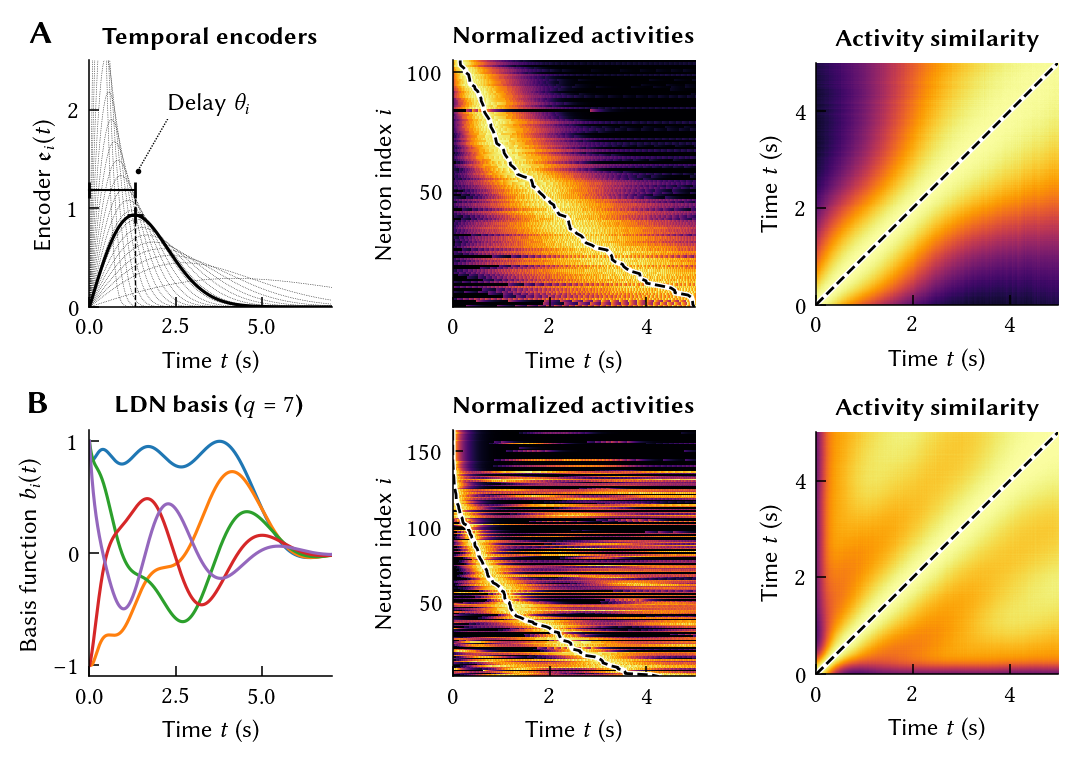

In [71]:
fig, axs = plt.subplots(2, 3, figsize=(6.25, 4.0), gridspec_kw={
    "hspace": 0.5,
    "wspace": 0.5,
})


for i in range(0, Ms.shape[1], 10):
    plot_single_delay_curve(axs[0, 0], Ms[:, i], thin=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 0])
plot_single_delay_curve(axs[0, 0], Ms[:, 75], show_annotation=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 150])

axs[0, 0].set_ylabel("Encoder $\\mathfrak{e}_i(t)$")
axs[0, 0].set_xlabel("Time $t$ (s)")
axs[0, 0].set_xlim(0, 7)
axs[0, 0].set_ylim(0, 2.5)
axs[0, 0].set_title("\\textbf{Temporal encoders}")

plot_lti_basis(axs[1, 0], A_ldn, B_ldn, ts)
axs[1, 0].set_title(f"\\textbf{{LDN basis ($q = {q}$)}}")

plot_activities(axs[0, 1], axs[0, 2], ts, ts_sort, As_flt, As_norm, As_norm_per_neuron)
plot_activities(axs[1, 1], axs[1, 2], ts, ts_ldn_sort, As_ldn_flt, As_ldn_norm, As_ldn_norm_per_neuron)

axs[0, 0].text(-0.25, 1.07, "\\textbf{A}", transform=axs[0, 0].transAxes, size=12)
axs[1, 0].text(-0.25, 1.07, "\\textbf{B}", transform=axs[1, 0].transAxes, size=12)

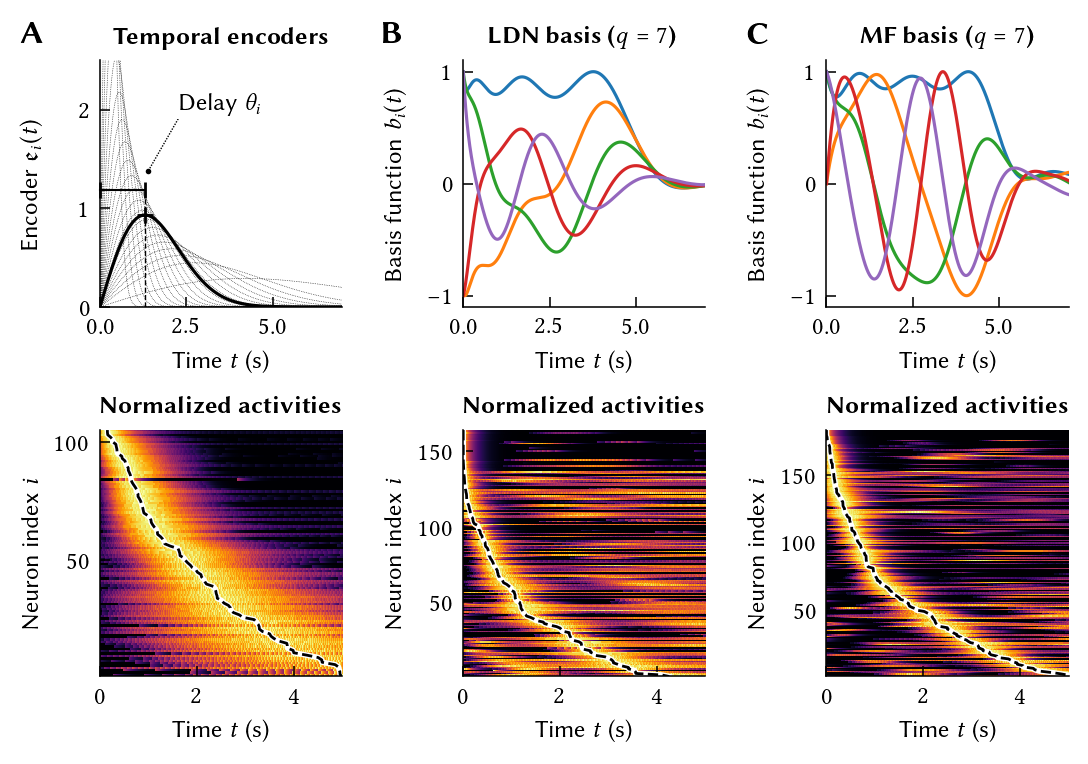

In [72]:
fig, axs = plt.subplots(2, 3, figsize=(6.25, 4.0), gridspec_kw={
    "hspace": 0.5,
    "wspace": 0.5,
})


for i in range(0, Ms.shape[1], 10):
    plot_single_delay_curve(axs[0, 0], Ms[:, i], thin=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 0])
plot_single_delay_curve(axs[0, 0], Ms[:, 75], show_annotation=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 150])

axs[0, 0].set_ylabel("Encoder $\\mathfrak{e}_i(t)$")
axs[0, 0].set_xlabel("Time $t$ (s)")
axs[0, 0].set_xlim(0, 7)
axs[0, 0].set_ylim(0, 2.5)
axs[0, 0].set_title("\\textbf{Temporal encoders}")

plot_lti_basis(axs[0, 1], A_ldn, B_ldn, ts)
axs[0, 1].set_title(f"\\textbf{{LDN basis ($q = {q}$)}}")

plot_lti_basis(axs[0, 2], A_mf, B_mf, ts)
axs[0, 2].set_title(f"\\textbf{{MF basis ($q = {q}$)}}")

plot_activities(axs[1, 0], None, ts, ts_sort, As_flt, As_norm, As_norm_per_neuron)
plot_activities(axs[1, 1], None, ts, ts_ldn_sort, As_ldn_flt, As_ldn_norm, As_ldn_norm_per_neuron)
plot_activities(axs[1, 2], None, ts, ts_mf_sort, As_mf_flt, As_mf_norm, As_mf_norm_per_neuron)

axs[0, 0].text(-0.33, 1.07, "\\textbf{A}", transform=axs[0, 0].transAxes, size=12)
axs[0, 1].text(-0.33, 1.07, "\\textbf{B}", transform=axs[0, 1].transAxes, size=12)
axs[0, 2].text(-0.33, 1.07, "\\textbf{C}", transform=axs[0, 2].transAxes, size=12)

fig.align_labels()

In [73]:
utils.save(fig, "time_cells.pdf")

Saving to time_cells.large.pdf
Extracting bounding box of file time_cells.large.pdf
Optimising PDF and saving to time_cells.pdf


GPL Ghostscript 9.56.1: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.56.1: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.
GPL Ghostscript 9.56.1: Can't embed the complete font LinBiolinumTB as it is too large, embedding a subset.


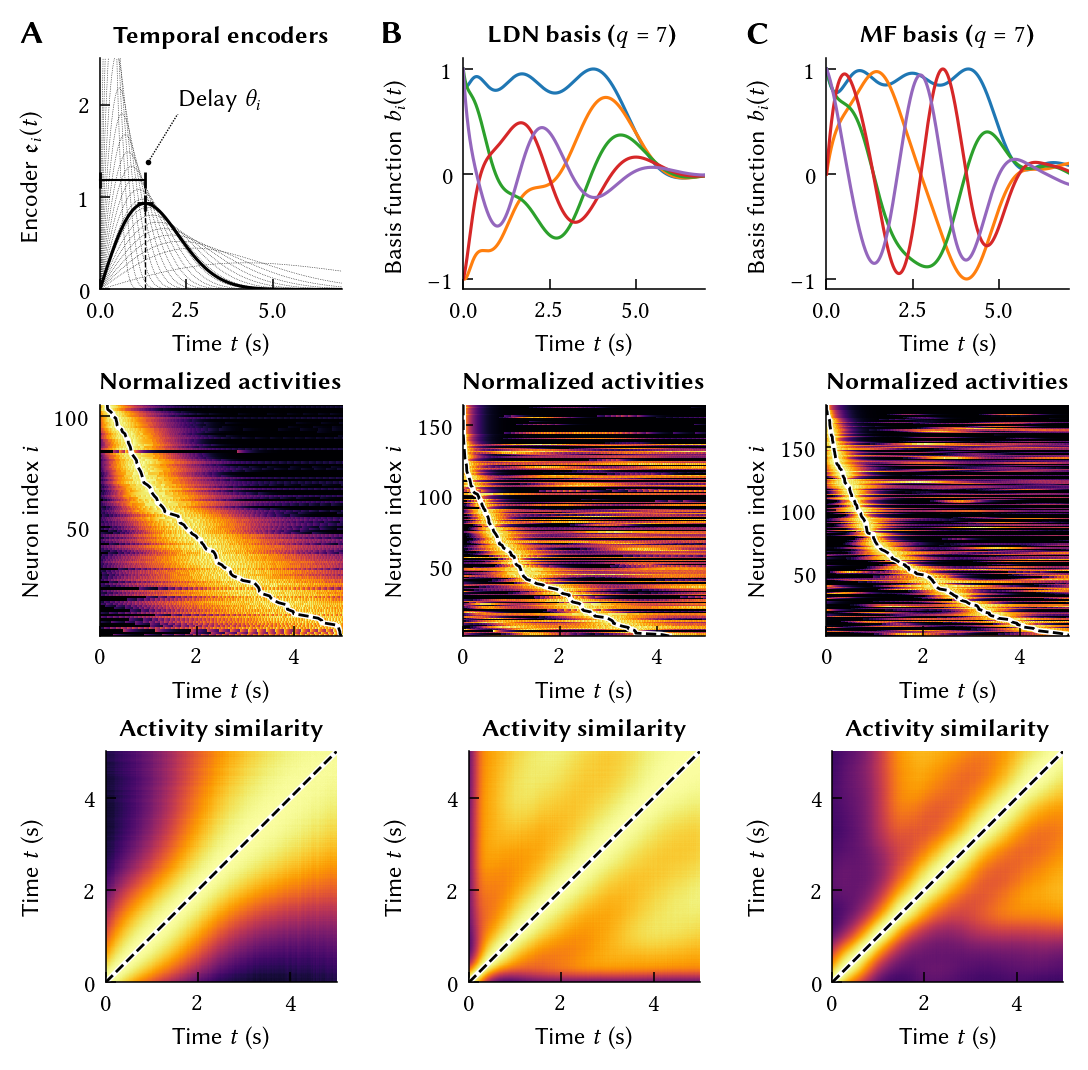

In [74]:
fig, axs = plt.subplots(3, 3, figsize=(6.25, 6.0), gridspec_kw={
    "hspace": 0.5,
    "wspace": 0.5,
})


for i in range(0, Ms.shape[1], 10):
    plot_single_delay_curve(axs[0, 0], Ms[:, i], thin=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 0])
plot_single_delay_curve(axs[0, 0], Ms[:, 75], show_annotation=True)
#plot_single_delay_curve(axs[0, 0], Ms[:, 150])

axs[0, 0].set_ylabel("Encoder $\\mathfrak{e}_i(t)$")
axs[0, 0].set_xlabel("Time $t$ (s)")
axs[0, 0].set_xlim(0, 7)
axs[0, 0].set_ylim(0, 2.5)
axs[0, 0].set_title("\\textbf{Temporal encoders}")

plot_lti_basis(axs[0, 1], A_ldn, B_ldn, ts)
axs[0, 1].set_title(f"\\textbf{{LDN basis ($q = {q}$)}}")

plot_lti_basis(axs[0, 2], A_mf, B_mf, ts)
axs[0, 2].set_title(f"\\textbf{{MF basis ($q = {q}$)}}")

plot_activities(axs[1, 0], axs[2, 0], ts, ts_sort, As_flt, As_norm, As_norm_per_neuron)
plot_activities(axs[1, 1], axs[2, 1], ts, ts_ldn_sort, As_ldn_flt, As_ldn_norm, As_ldn_norm_per_neuron)
plot_activities(axs[1, 2], axs[2, 2], ts, ts_mf_sort, As_mf_flt, As_mf_norm, As_mf_norm_per_neuron)

axs[0, 0].text(-0.33, 1.07, "\\textbf{A}", transform=axs[0, 0].transAxes, size=12)
axs[0, 1].text(-0.33, 1.07, "\\textbf{B}", transform=axs[0, 1].transAxes, size=12)
axs[0, 2].text(-0.33, 1.07, "\\textbf{C}", transform=axs[0, 2].transAxes, size=12)

fig.align_labels()